# Internal QA sheets 

This script is designed to test the VD outputs of multiple scenarios 

Scenarios can be selected by version number and "run" name (eg kea, tui, etc)

### Notes 

We note that this will not consider the current post-processing system of "raw", "main", and "clean" data. 

This attempts to look at the actual model outputs while keeping handling as light as possible. 

Long term, the work done here might also be used for post-processing. Current post-processing has extra data handling which means it deviates from model outputs. This should be cleaned up. 

Separately, we want to create a big cool graph object for any given scenario run. This will be a separate project

### Concordance

The concordance file (containing Att/Proc/Com metadata) is key to interpreting the TIMES-NZ specific outputs.

The actual concordance data can be adjusted. It is found here:

`TIMES-NZ-OUTPUT-PROCESSING/data/input/concordance/attribute_process_commodity_concordance.csv`. 

The interactive version can be browsed here: 

`TIMES-NZ-OUTPUT-PROCESSING/data/input/concordance/times_concordance_lookup.html`

If the data is updated, the lookup file can be updated by navigating to `TIMES-NZ-OUTPUT-PROCESSING\data\input\concordance` and running `create_lookup.py`

### Steps: 

1) Define scenarios, versions 
2) Define methods for accessing relevant attributes/processes/fuels from the specified scenarios/versions
3) Run check testing for any differences: 
    - new/missing attributes/processes/fuels 
    - within matching attributes/processes/fuels, where values are different
    - output a report 
4) Output charts for visual assessments of differences
    - Input differences (not VD files! This will need to wait for a better input data structure) 
    - Emissions
      - Total
      - Sector
      - Fuel 
    - Supply
      - to assess value of this? Not sure how interesting it is 
    - End use
      - Sectors by fuel
      - ESD (tech-agnostic)
      - Technology uptake 
    - Generation
      - Generation mix
      - timeslices/peaking/peak cap
      - Required build
    - Prices
      - (not input prices, these should be covered separately)
      - Need to explore these better and ensure they make sense











## SETUP

In [4]:
# libraries 
import pandas as pd
# import numpy as np
import re
import os 
from pathlib import Path


import seaborn as sns
import matplotlib.pyplot as plt

In [22]:
# scenario definitions 

# these should match the folder names in times_scenarios/ that we want to assess 
qa_runs = ["tui-v2_1_2", "tui-v2_1_3"]
# we could do something fancy by saying like "i want every version of tui" or whatever,
# but this is flexible to naming conventions changing in future 


In [ ]:
# checking directories and data 

# TIMES_LOCATION = os.getcwd()

# go up one 
TIMES_LOCATION = os.path.dirname(os.getcwd())
# identify data location 
TIMES_OUTPUTS_RAW = os.path.join(TIMES_LOCATION, "TIMES-NZ-GAMS", "times_scenarios")

# test that your scenarios exist 

# (to do: go down a bit and make sure the vd files exist)
available_runs = os.listdir(TIMES_OUTPUTS_RAW)
print(f"Checking data availability:")

for run in qa_runs: 
    if run not in available_runs:
        print(f"Warning: `{run}` cannot be found in the current run data. Ensure you have processed veda correctly")
    else: 
        print(f"`{run}` found :)")






In [43]:
# data retrival functions 


def read_vd(filepath):
    """
    Reads a VD file, using column names extracted from the file's
    header with regex, skipping non-CSV formatted header lines.

    :param filepath: Path to the VD file.
    :param scen_label: Label for the 'scen' column for rows from this file.
    """
    dimensions_pattern = re.compile(r"\*\s*Dimensions-")

    # Determine the number of rows to skip and the column names
    with open(filepath, "r", encoding="utf-8") as file:
        columns = None
        skiprows = 0
        for line in file:
            if dimensions_pattern.search(line):
                columns_line = line.split("- ")[1].strip()
                columns = columns_line.split(";")
                continue
            if line.startswith('"'):
                break
            skiprows += 1

    # Read the CSV file with the determined column names and skiprows
    vd_df = pd.read_csv(
        filepath, skiprows=skiprows, names=columns, header=None, low_memory=False
    )
    return vd_df


def get_attribute_df_single_run(attribute, run_name): 
    """
    Reads a TIMES vd file and returns a dataframe filtered to a specific attribute 
    
    Parameters:
    attribute (str): Attribute from a TIMES vd file to filter on 
    run_name (str): The name of the run this file is from. This must exist in the specified df
    
    Returns:
    Dataframe - untouched vd output but on a specific attribute and with a run label 
    """

    filepath = os.path.join(TIMES_OUTPUTS_RAW, run_name, f"{run_name}.vd")
    vd = read_vd(filepath)
    vd = vd[vd["Attribute"] == attribute]
    vd["Scenario"] = run_name
    return vd
    
def add_concordance_to_vd(df):
    """
    Takes a TIMES VD file with Attribute/Process/Commodity data, and adds the local concordance file to it 
    Hardcodes the concordance file location, which must exist
    
    Parameters:
    df (str): the pandas dataframe we're adding the concordance to   

    Returns:
    a df with the new variables attached
    """

    concordance_filepath = os.path.join(TIMES_LOCATION,
                                        "TIMES-NZ-OUTPUT-PROCESSING/data/input/concordance/",
                                        "attribute_process_commodity_concordance.csv")
    
    concordance_data = pd.read_csv(concordance_filepath)

    df = df.merge(concordance_data,
                  how = "left",
                  on = ["Attribute", "Process", "Commodity"])
    return df

    

def get_veda_data(attribute, runs = qa_runs):
    """
    Combines previous functions to get the same attribute data for all relevant runs
    then attach the concordance file for easy perusal. 
    
    Parameters:
    attribute (str): the VD attribute this pulls
    runs (array): an array of run names stored as strings. Defaults to the `qa_runs` defined earlier 

    Returns:
    a df 
    """
    df = pd.DataFrame()

    for run in runs: 
        vd_df = get_attribute_df_single_run(attribute, run)
        df = pd.concat([df, vd_df])
    
    df = add_concordance_to_vd(df)

    return df


    

In [ ]:
# get data 
fuel_use_df = get_veda_data("VAR_FIn")
output_df = get_veda_data("VAR_FOut")
cap_df = get_veda_data("VAR_Cap")


In [63]:
# define aggregation categories
# to this you can group by other stuff if needed like process/commopdity/sector or whatever but this will form the baseline? 
standard_group_categories = [
    "Attribute",   
    "Period",
    "Scenario",
    "Unit"
]

## EMISSIONS

In [ ]:
# TOTAL EMISSIONS 
totcap_data = output_df[output_df["Commodity"] == "TOTCO2"]
print(f"Warning: making manual adjustments to units for TOTCO2. This should really be done in the concordance file if these are needed")
totcap_data.loc[:,"Unit"] = "ktco2e"

# all emissions by scenario, year 
totcap_data = (
    totcap_data 
    .groupby(standard_group_categories)
    .sum(["PV"])
    .reset_index()
)
# convert to MT 
totcap_data["PV"] /= 1000
totcap_data["Unit"] = "MT CO2"

sns.relplot(
    data = totcap_data, 
    x = "Period", y = "PV", hue = "Scenario",
    kind = "line",
)
plt.title("Total Emissions")
plt.xlabel("Year")
plt.ylabel("Mt CO2") # not co2e?? 
plt.show()


In [ ]:
# POSITIVE EMISSIONS

totcap_data = output_df[output_df["Commodity"] == "TOTCO2"]
print(f"Warning: making manual adjustments to units for TOTCO2. This should really be done in the concordance file if these are needed")
totcap_data.loc[:,"Unit"] = "ktco2e"

totcap_data_positive = totcap_data[totcap_data["PV"] > 0]

# all emissions by scenario, year 
totcap_data_positive = (
    totcap_data_positive 
    .groupby(standard_group_categories)
    .sum(["PV"])
    .reset_index()
)
# convert to MT 
totcap_data_positive["PV"] /= 1000
totcap_data_positive["Unit"] = "MT CO2"

sns.relplot(
    data = totcap_data_positive, 
    x = "Period", y = "PV", hue = "Scenario",
    kind = "line"    
)
plt.title("Positive Emissions")
plt.xlabel("Year")
plt.ylabel("Mt CO2") # not co2e?? 
plt.show()

In [ ]:
# NEGATIVE EMISSIONS

totcap_data = output_df[output_df["Commodity"] == "TOTCO2"]
print(f"Warning: making manual adjustments to units for TOTCO2. This should really be done in the concordance file if these are needed")
totcap_data.loc[:,"Unit"] = "ktco2e"

totcap_data_negative = totcap_data[totcap_data["PV"] < 0]

# all emissions by scenario, year 
totcap_data_negative = (
    totcap_data_negative 
    .groupby(standard_group_categories)
    .sum(["PV"])
    .reset_index()
)
# convert to MT 
totcap_data_negative["PV"] /= 1000
totcap_data_negative["Unit"] = "MT CO2"

sns.relplot(
    data = totcap_data_negative, 
    x = "Period", y = "PV", hue = "Scenario",
    kind = "line"    
)
plt.title("NEGATIVE Emissions")
plt.xlabel("Year")
plt.ylabel("Mt CO2") # not co2e?? 
plt.show()

In [ ]:
# EMISSIONS BY SECTOR


detailed_emissions = output_df[output_df["Parameters"] == "Emissions"]
# hello can we please check that the emissions parameter covers everything 
# this should add to totco2
# the original gets everything where the commodity has a co2 in it but excludes all the totco2 


detailed_emissions = (
    detailed_emissions
    .groupby(standard_group_categories + ["Sector"])
    .sum("PV")
    .reset_index()
)
detailed_emissions["PV"] /= 1000

g = sns.relplot(
    data = detailed_emissions, 
    x = "Period", y = "PV", hue = "Scenario",
    kind = "line",
    col = "Sector", 
    col_wrap = 5,
    facet_kws={'sharey': False}
)
g.figure.suptitle("Emissions by Sector", y = 1.02, size = 20)
g.set_ylabels("MT CO2")
g.set_xlabels("Year")

g.set_titles(col_template="{col_name}", size = 14)
g




In [ ]:
# EMISSIONS BY FUEL


detailed_emissions = output_df[output_df["Parameters"] == "Emissions"]
# hello can we please check that the emissions parameter covers everything 
# this should add to totco2
# the original gets everything where the commodity has a co2 in it but excludes all the totco2 


detailed_emissions = (
    detailed_emissions
    .groupby(standard_group_categories + ["Fuel"])
    .sum("PV")
    .reset_index()
)
detailed_emissions["PV"] /= 1000

g = sns.relplot(
    data = detailed_emissions, 
    x = "Period", y = "PV", hue = "Scenario",
    kind = "line",
    col = "Fuel", 
    col_wrap = 5,
    facet_kws={'sharey': False}
)
g.figure.suptitle("Emissions by Fuel", y = 1.02, size = 20)
g.set_ylabels("MT CO2")
g.set_xlabels("Year")

g.set_titles(col_template="{col_name}", size = 14)
g


In [ ]:
# EMISSIONS BY FUEL 

detailed_emissions = output_df[output_df["Parameters"] == "Emissions"]

detailed_emissions = (
    detailed_emissions
    .groupby(standard_group_categories + ["Fuel"])
    .sum("PV")
    .reset_index()
)

g = sns.relplot(
    data = detailed_emissions, 
    x = "Period", y = "PV", hue = "Scenario",
    kind = "line",
    col = "Fuel", 
    col_wrap = 5,
    facet_kws={'sharey': False}
)
g.figure.suptitle("Emissions by Fuel", y = 1.02, size = 20)
g.set_titles(col_template="{col_name}", size = 14)
plt.ylabel("MT CO2")

g


## ENERGY DEMAND

In [ ]:
# ELECTRICITY DEMAND 

ele_demand = fuel_use_df[fuel_use_df["Parameters"] == "Fuel Consumption"]
ele_demand = ele_demand[ele_demand["Fuel"] == "Electricity"]


ele_demand = (
    ele_demand
    .groupby(standard_group_categories + ["Fuel"])
    .sum("PV")
    .reset_index()
)

ele_demand["PV"] /= 3.6
ele_demand["Unit"] = "TWh"

sns.relplot(
    data = ele_demand, 
    x = "Period", y = "PV", hue = "Scenario",
    kind = "line"    
)

plt.title("Total ele demand")
plt.xlabel("Year")
plt.ylabel("TWh") # not co2e?? 
plt.show()

ele_demand



In [ ]:
# ELECTRICIY DEMAND BY SECTOR

ele_demand = fuel_use_df[fuel_use_df["Parameters"] == "Fuel Consumption"]
ele_demand = ele_demand[ele_demand["Fuel"] == "Electricity"]


ele_demand = (
    ele_demand
    .groupby(standard_group_categories + ["Sector"])
    .sum("PV")
    .reset_index()
)

ele_demand["PV"] /= 3.6
ele_demand["Unit"] = "TWh"

g = sns.relplot(
    data = ele_demand, 
    x = "Period", y = "PV", hue = "Scenario",
    kind = "line",
    col = "Sector", 
    col_wrap = 5,
    facet_kws={'sharey': False}
)
g.figure.suptitle("Electricity Demand by Sector", y = 1.1, size = 20)
g.set_titles(col_template="{col_name}", size = 14)
plt.ylabel("TWh")

g




In [ ]:
# ELECTRICIY DEMAND BY SUBSECTOR

ele_demand = fuel_use_df[fuel_use_df["Parameters"] == "Fuel Consumption"]
ele_demand = ele_demand[ele_demand["Fuel"] == "Electricity"]


ele_demand = (
    ele_demand
    .groupby(standard_group_categories + ["Subsector"])
    .sum("PV")
    .reset_index()
)

ele_demand["PV"] /= 3.6
ele_demand["Unit"] = "TWh"

g = sns.relplot(
    data = ele_demand, 
    x = "Period", y = "PV", hue = "Scenario",
    kind = "line",
    col = "Subsector", 
    col_wrap = 5,
    facet_kws={'sharey': True}
    # facet_kws={'sharey': False}
)
g.figure.suptitle("Electricity Demand by Sector", y = 1.01, size = 20)
g.set_titles(col_template="{col_name}", size = 14)
plt.ylabel("TWh")

g



## SERVICE DEMAND

In [ ]:
# ENERGY SERVICE DEMAND 

esd_data = output_df[output_df["Parameters"] == "End Use Demand"]


esd_data = (
    esd_data.groupby(standard_group_categories + ["Sector", "FuelGroup"])     
    .sum("PV")
    .reset_index()
)

colors = sns.color_palette("deep")

# chart tests 
g = sns.FacetGrid(esd_data, col='Scenario', row='Sector', height=4, aspect=1.5)

def stacked_area(data, time_col, value_col, category_col, color=None, **kwargs):    
    pivoted = data.pivot_table(
        index=time_col, 
        columns=category_col, 
        values=value_col,
        aggfunc='sum'
    ).fillna(0)
    
    plt.stackplot(
        pivoted.index, 
        pivoted.T,
        labels=pivoted.columns,
        colors = colors,
        alpha=0.8
    )
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

g.map_dataframe(stacked_area, 
    time_col='Period', 
    value_col='PV', 
    category_col='FuelGroup'
)

# titles 
g.figure.suptitle('Energy Service Demand', y=1.02)
g.add_legend(bbox_to_anchor=(1.05, 1), loc='upper left')


In [ ]:
# ROAD TRANSPORT ENERGY SERVICE DEMAND - TOTAL

# copy above stuff and get a bunch of areas on how this is being filled 

# this is missing biofuel which is a problem. It looks like biofuel was not added correctly.
# surely we should just add biofuel like any other fuel with prices and efficiencies and EFs and everything


vkt_demand = output_df[output_df["Parameters"] == "Distance Travelled"]

vkt_demand = (
    vkt_demand.groupby(standard_group_categories + ["Fuel"])
    .sum("PV")
    .reset_index()
)
vkt_demand

g = sns.FacetGrid(vkt_demand, col='Scenario', aspect = 1.5)  

# Map the plotting function
g.map_dataframe(stacked_area, 
    time_col='Period', 
    value_col='PV', 
    category_col='Fuel'
)

g.figure.suptitle('VKT Demand', y=1.02)
g.add_legend(bbox_to_anchor=(1.05, 1), loc='upper left')
g.set_xlabels("Year")
g.set_ylabels("Billion VKT")


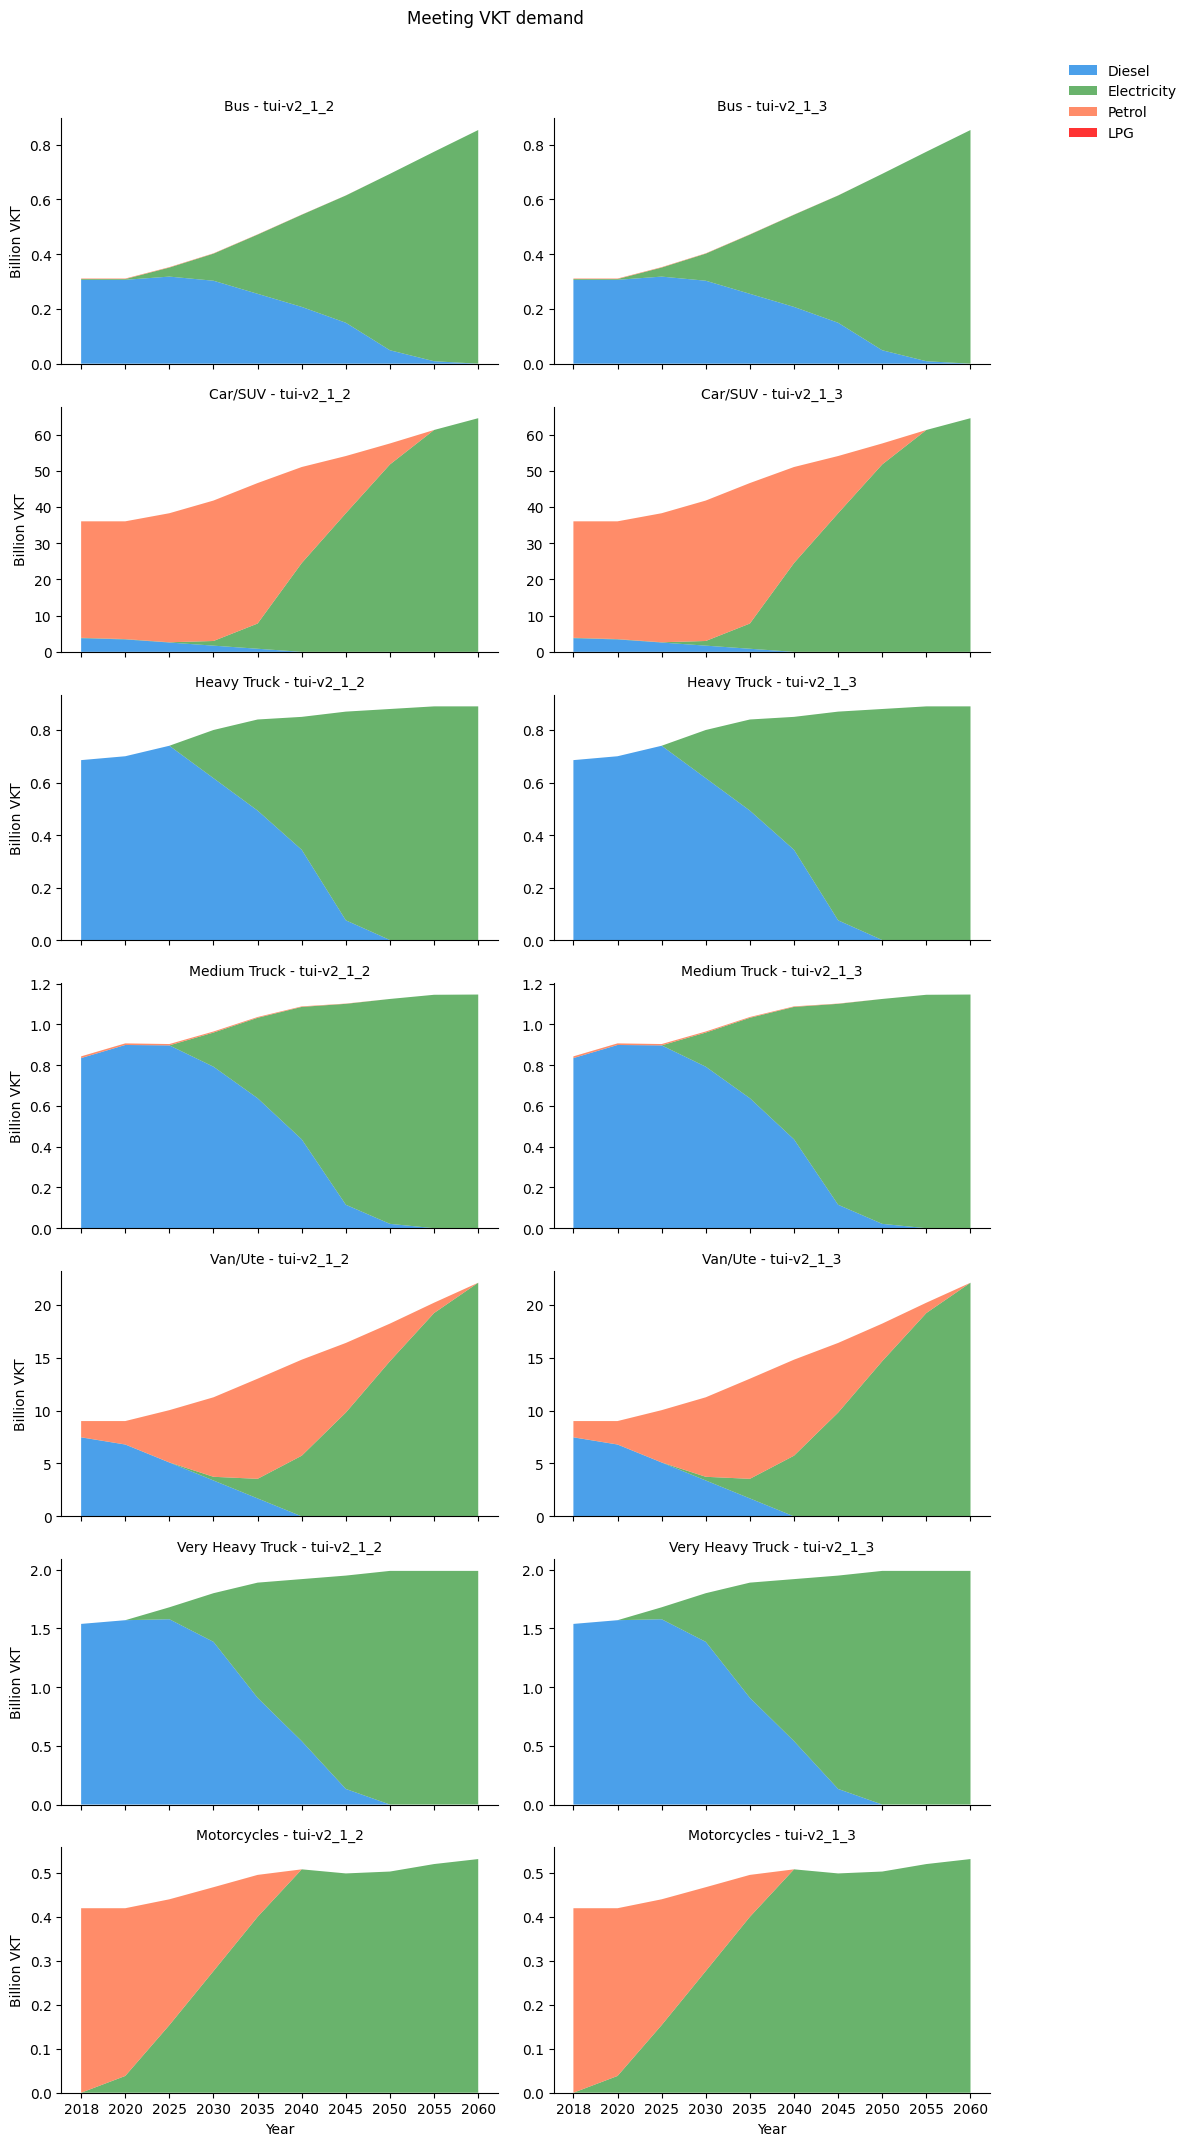

In [219]:
# ROAD TRANSPORT ENERGY SERVICE DEMAND BY VEHICLE

 
vkt_demand = output_df[output_df["Parameters"] == "Distance Travelled"]

vkt_demand = (
    vkt_demand.groupby(standard_group_categories + ["Fuel", "Enduse"])
    .sum("PV")
    .reset_index()
)

g = sns.FacetGrid(vkt_demand, col='Scenario', row = 'Enduse', aspect = 1.5, sharey=False)  



def stacked_area(data, time_col, value_col, category_col, color=None, **kwargs):
    # Sort the categories to ensure consistent order
    categories = sorted(data[category_col].unique())
    
    pivoted = data.pivot_table(
        index=time_col, 
        columns=category_col, 
        values=value_col,
        aggfunc='sum'
    ).fillna(0)
    
    # Ensure columns are in the same order as categories
    pivoted = pivoted[categories]
    
    # Have to do really weird annoying colour hacks here. There must be an easier way?? 
    colors = {
        'Diesel': '#1e88e5',
        'Electricity': '#43a047',
        'Petrol': '#ff7043',
        'LPG': 'red'
    }
    
    # Use the same order for colors as the data
    color_list = [colors[cat] for cat in categories]
    
    plt.stackplot(
        pivoted.index, 
        pivoted.T,
        labels=categories,  # Use same category order
        colors=color_list,  # Use matched colors
        alpha=0.8, 
    )

# Map the plotting function
g.map_dataframe(stacked_area, 
    time_col='Period', 
    value_col='PV', 
    category_col='Fuel'
)

g.figure.suptitle('Meeting VKT demand', y=1.02)
g.add_legend(bbox_to_anchor=(1.05, 1), loc='upper left')
g.set_xlabels("Year")
g.set_ylabels("Billion VKT")

g.set_titles('{row_name} - {col_name}')


plt.tight_layout()

In [ ]:
# ELECTRICITY DEMAND BY TIMESLICE 


# want to display the timeslices we have available
# to do this need to plug into what each timeslice represents 

# Currently setup like this: (24 slices)


"""
Season	Weekly	DayNite

SUM     WK-	      D
FAL     WE-	      N
WIN     	      P
SPR     	

"""

# a couple possibilities for how to represent: 

# average of demand per year, where we split out each bar by the number of hours in it then fill each bar with the elecricity use for that period 
# this should come off of base year but we can take the future years to see what changes 


# peak demand in GW each year (timeseries)
# should try align this with the EA official peak data 

## EVERYTHING BELOW THIS LINE IS BAD AND OLD 

In [ ]:
# currently set up to just take every version of main 
# NOTE that individual tables are currently setup to always be kea + tui 
# really this needs to be generalised much further to allow for any scenario combinations at all 
# so we might need to break down output methods to allow for this 
main_df = combine_versioned_tables(TIMES_OUTPUTS_PROCESSED)
clean_df = combine_versioned_tables(TIMES_OUTPUTS_PROCESSED, table_type = "clean")
raw_df = combine_versioned_tables(TIMES_OUTPUTS_PROCESSED, table_type = "raw")

## Emissions

In [ ]:
 # hey you need to think about how you do your data a bit better here this feels messy

def aggregate_emissions_data(df, group_cols):
    df = df[df["CommoditySet"] == ".ENV."]
    df = df.groupby(group_cols).sum("Value").reset_index()
    # df["Value"] = df["Value"]/1000
    # df["Unit"] = "Mt CO2"
    return df

emissions_group_cols_agg = ["Scenario", "Period", "Unit", "Parameters"]

chart_data = aggregate_emissions_data(main_df, emissions_group_cols_agg)
#unit = chart_data["Unit"].unique()

sns.relplot(
    data = chart_data, 
    x = "Period", y = "Value", hue = "Scenario",
    kind = "line",
)
plt.title("Total Emissions")
plt.xlabel("Year")
plt.ylabel("Mt CO2")# not co2e??
 


## Emissions by fuel

In [ ]:

emissions_group_cols_agg = ["Scenario", "Period", "Unit", "Parameters", "Fuel"]
chart_data = aggregate_emissions_data(clean_df, emissions_group_cols_agg)


# chart_data
g = sns.relplot(
    data = chart_data, 
    x = "Period", y = "Value", hue = "Scenario",
    kind = "line",
    col = "Fuel", 
    col_wrap = 3,
    facet_kws={'sharey': False}
)
g.figure.suptitle("Emissions by Fuel", y = 1.02, size = 20)
g.set_titles(col_template="{col_name}", size = 14)
plt.ylabel("MT CO2")

g

## Emissions by Sector

In [ ]:
emissions_group_cols_agg = ["Scenario", "Period", "Unit", "Parameters", "Sector"]
chart_data = aggregate_emissions_data(clean_df, emissions_group_cols_agg)

# chart_data
g = sns.relplot(
    data = chart_data, 
    x = "Period", y = "Value", hue = "Scenario",
    kind = "line",
    col = "Sector", 
    col_wrap = 3,
    facet_kws={'sharey': False}
)
g.figure.suptitle("Emissions by Sector", y = 1.02, size = 20)
g.set_titles(col_template="{col_name}", size = 14)
plt.ylabel("MT CO2")

## Supply

In [ ]:
clean_df

## End Use

In [ ]:
clean_df.head()

def aggregate_demand_data(df, group_cols):
    df = df[df["Parameters"] == "End Use Demand"]
    df = df.groupby(group_cols).sum("Value").reset_index()    
    return df


demand_group_cols = ["Scenario", "Period", "Sector", "Unit"]

chart_data = aggregate_demand_data(clean_df, demand_group_cols)

unit = chart_data["Unit"].unique()
g = sns.relplot(
    data = chart_data, 
    x = "Period", y = "Value", hue = "Scenario",
    kind = "line",
    col = "Sector", 
    col_wrap = 3,
    facet_kws={'sharey': False}
)
g.figure.suptitle("Demand by Sector", y = 1.02, size = 20)
g.set_titles(col_template="{col_name}", size = 14)
plt.ylabel(unit)



## Agriculture

## energy demand? 

## technology use? 



In [10]:
def make_sector_demand_chart(sector, facet_variable, df = clean_df):
    demand_cols = ["Scenario", "Period", "Sector", "Unit", facet_variable]    

    chart_data = aggregate_demand_data(df, demand_cols)
    chart_data = chart_data[chart_data["Sector"] == sector]

    unit = chart_data["Unit"].unique()[0]

    g = sns.relplot(
        data = chart_data, 
        x = "Period", y = "Value", hue = "Scenario",
        kind = "line",
        col = facet_variable,         
        col_wrap = 4,
        facet_kws={'sharey': False}
        )
    
    g.figure.suptitle(f"{sector} energy demand by {facet_variable}", y = 1.05, size = 20)
    g.set_titles(col_template="{col_name}", size = 14)
    g.set_axis_labels("Year", unit)   


def make_sector_tech_x_fuel_chart(sector, df = clean_df):

    demand_cols = ["Scenario", "Period", "Sector", "Unit", "Technology_Group", "Fuel"]   

    chart_data = aggregate_demand_data(df, demand_cols)
    
    chart_data = chart_data[chart_data["Sector"] == sector]

    unit = chart_data["Unit"].unique()[0]

    g = sns.relplot(
        data = chart_data, 
        x = "Period", y = "Value", hue = "Scenario",
        kind = "line",
        col = "Technology_Group",         
        row = "Fuel",
        # col_wrap = 4,
        facet_kws={'sharey': False}
        )
    
    g.figure.suptitle(f"{sector} energy demand", y = 1.05, size = 20)
    g.set_titles(col_template="{col_name}", size = 14)
    g.set_axis_labels("Year", unit)   
    

def make_sector_demand_charts(sector):
    for variable in ["Fuel", "Subsector", "Technology_Group"]:
        make_sector_demand_chart(sector, variable)
    # make_sector_tech_x_fuel_chart(sector)



In [ ]:
make_sector_demand_charts("Agriculture")

In [ ]:
make_sector_demand_charts("Industry")

In [ ]:
make_sector_demand_charts("Commercial")

In [ ]:
make_sector_demand_charts("Residential")

In [ ]:
make_sector_demand_charts("Transport")

want ESD (ie control for the efficiency of fuel used) so we can get the purest form of activity demand

then we would see how that is serviced just to get a better intuition 

for now a better approach might be to get a technology group X fuel split? 

## Generation

## Prices